In [90]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback

from sklearn.metrics import accuracy_score

In [118]:
image_resize = 20
Nber_of_breeds = 8

In [119]:
print("X_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl")

X_train_20x20_8.pkl


In [120]:
X_train = pickle.load(open("pickles/X_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
X_test = pickle.load(open("pickles/X_test_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
y_train = pickle.load(open("pickles/y_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
y_test = pickle.load(open("pickles/y_test_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
labels_name = pickle.load(open("pickles/labels_name_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))

In [121]:
dropout = 0.3
fully_connected_nodes = 200

#create model
model = Sequential()
#add model layers
model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=(image_resize,image_resize,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(Conv2D(64, kernel_size=4, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

# model.add(Conv2D(256, kernel_size=3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(fully_connected_nodes, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(Nber_of_breeds, activation='softmax'))

In [122]:
epochs = 100
batch_size = 20
model_name = "model_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds)
checkpointer = ModelCheckpoint(filepath="models/" + model_name + ".hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping, TQDMNotebookCallback()], verbose=0)


Epoch 00001: val_loss improved from inf to 2.07289, saving model to models/model_20x20_8.hdf5



Epoch 00002: val_loss improved from 2.07289 to 2.06859, saving model to models/model_20x20_8.hdf5



Epoch 00003: val_loss improved from 2.06859 to 2.05949, saving model to models/model_20x20_8.hdf5



Epoch 00004: val_loss improved from 2.05949 to 2.03863, saving model to models/model_20x20_8.hdf5



Epoch 00005: val_loss improved from 2.03863 to 2.00891, saving model to models/model_20x20_8.hdf5



Epoch 00006: val_loss improved from 2.00891 to 1.96034, saving model to models/model_20x20_8.hdf5



Epoch 00007: val_loss improved from 1.96034 to 1.90266, saving model to models/model_20x20_8.hdf5



Epoch 00008: val_loss improved from 1.90266 to 1.85218, saving model to models/model_20x20_8.hdf5



Epoch 00009: val_loss improved from 1.85218 to 1.81169, saving model to models/model_20x20_8.hdf5



Epoch 00010: val_loss improved from 1.81169 to 1.77956, saving model to models/model_20x20_8.hdf5



Epoch 00011: val_loss improved from 1.77956 to 1.77073, saving model to models/model_20x20_8.hdf5



Epoch 00012: val_loss did not improve from 1.77073



Epoch 00013: val_loss improved from 1.77073 to 1.72087, saving model to models/model_20x20_8.hdf5



Epoch 00014: val_loss did not improve from 1.72087



Epoch 00015: val_loss improved from 1.72087 to 1.70045, saving model to models/model_20x20_8.hdf5



Epoch 00016: val_loss did not improve from 1.70045



Epoch 00017: val_loss improved from 1.70045 to 1.68693, saving model to models/model_20x20_8.hdf5



Epoch 00018: val_loss did not improve from 1.68693



Epoch 00019: val_loss did not improve from 1.68693



Epoch 00020: val_loss improved from 1.68693 to 1.67861, saving model to models/model_20x20_8.hdf5



Epoch 00021: val_loss improved from 1.67861 to 1.66937, saving model to models/model_20x20_8.hdf5



Epoch 00022: val_loss improved from 1.66937 to 1.66884, saving model to models/model_20x20_8.hdf5



Epoch 00023: val_loss improved from 1.66884 to 1.65586, saving model to models/model_20x20_8.hdf5



Epoch 00024: val_loss did not improve from 1.65586



Epoch 00025: val_loss did not improve from 1.65586



Epoch 00026: val_loss did not improve from 1.65586



Epoch 00027: val_loss improved from 1.65586 to 1.64197, saving model to models/model_20x20_8.hdf5



Epoch 00028: val_loss did not improve from 1.64197



Epoch 00029: val_loss did not improve from 1.64197



Epoch 00030: val_loss did not improve from 1.64197



Epoch 00031: val_loss did not improve from 1.64197



Epoch 00032: val_loss did not improve from 1.64197



Epoch 00033: val_loss did not improve from 1.64197



Epoch 00034: val_loss improved from 1.64197 to 1.64173, saving model to models/model_20x20_8.hdf5



Epoch 00035: val_loss improved from 1.64173 to 1.63185, saving model to models/model_20x20_8.hdf5



Epoch 00036: val_loss did not improve from 1.63185



Epoch 00037: val_loss did not improve from 1.63185



Epoch 00038: val_loss did not improve from 1.63185



Epoch 00039: val_loss improved from 1.63185 to 1.62496, saving model to models/model_20x20_8.hdf5



Epoch 00040: val_loss did not improve from 1.62496



Epoch 00041: val_loss did not improve from 1.62496



Epoch 00042: val_loss did not improve from 1.62496



Epoch 00043: val_loss did not improve from 1.62496



Epoch 00044: val_loss did not improve from 1.62496



Epoch 00045: val_loss improved from 1.62496 to 1.61768, saving model to models/model_20x20_8.hdf5



Epoch 00046: val_loss did not improve from 1.61768



Epoch 00047: val_loss did not improve from 1.61768



Epoch 00048: val_loss improved from 1.61768 to 1.61186, saving model to models/model_20x20_8.hdf5



Epoch 00049: val_loss did not improve from 1.61186



Epoch 00050: val_loss did not improve from 1.61186



Epoch 00051: val_loss did not improve from 1.61186



Epoch 00052: val_loss did not improve from 1.61186



Epoch 00053: val_loss did not improve from 1.61186



Epoch 00054: val_loss did not improve from 1.61186



Epoch 00055: val_loss did not improve from 1.61186



Epoch 00056: val_loss did not improve from 1.61186



Epoch 00057: val_loss did not improve from 1.61186



Epoch 00058: val_loss did not improve from 1.61186



Epoch 00059: val_loss did not improve from 1.61186



Epoch 00060: val_loss did not improve from 1.61186



Epoch 00061: val_loss did not improve from 1.61186



Epoch 00062: val_loss improved from 1.61186 to 1.60927, saving model to models/model_20x20_8.hdf5



Epoch 00063: val_loss did not improve from 1.60927



Epoch 00064: val_loss did not improve from 1.60927



Epoch 00065: val_loss did not improve from 1.60927



Epoch 00066: val_loss did not improve from 1.60927



Epoch 00067: val_loss did not improve from 1.60927



Epoch 00068: val_loss did not improve from 1.60927



Epoch 00069: val_loss did not improve from 1.60927



Epoch 00070: val_loss did not improve from 1.60927



Epoch 00071: val_loss did not improve from 1.60927



Epoch 00072: val_loss did not improve from 1.60927



Epoch 00073: val_loss did not improve from 1.60927



Epoch 00074: val_loss did not improve from 1.60927



Epoch 00075: val_loss did not improve from 1.60927



Epoch 00076: val_loss did not improve from 1.60927



Epoch 00077: val_loss did not improve from 1.60927



Epoch 00078: val_loss did not improve from 1.60927



Epoch 00079: val_loss did not improve from 1.60927



Epoch 00080: val_loss did not improve from 1.60927



Epoch 00081: val_loss did not improve from 1.60927



Epoch 00082: val_loss did not improve from 1.60927



Epoch 00083: val_loss did not improve from 1.60927



Epoch 00084: val_loss did not improve from 1.60927



Epoch 00085: val_loss did not improve from 1.60927



Epoch 00086: val_loss did not improve from 1.60927



Epoch 00087: val_loss did not improve from 1.60927



Epoch 00088: val_loss did not improve from 1.60927



Epoch 00089: val_loss did not improve from 1.60927



Epoch 00090: val_loss did not improve from 1.60927



Epoch 00091: val_loss did not improve from 1.60927



Epoch 00092: val_loss did not improve from 1.60927



Epoch 00093: val_loss did not improve from 1.60927



Epoch 00094: val_loss did not improve from 1.60927



Epoch 00095: val_loss did not improve from 1.60927



Epoch 00096: val_loss did not improve from 1.60927
Epoch 00096: early stopping


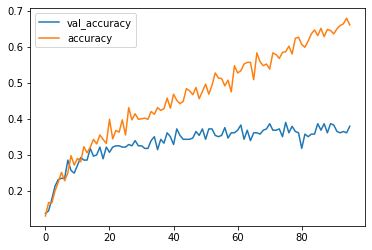

In [124]:
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.plot(history.history["accuracy"], label = "accuracy")
plt.legend();

In [125]:
image_resizes = [20, 40, 60, 80]
Nber_of_breeds = 8

models = []
for size in image_resizes:
    models.append("model_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds))
models

['model_20x20_8', 'model_40x40_8', 'model_60x60_8', 'model_80x80_8']

In [127]:
accuracies = []
for size, model_name in zip(image_resizes, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))

Loading model: model_20x20_8
Loading X_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_40x40_8
Loading X_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8
Loading X_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_80x80_8
Loading X_test pickle...
Getting predictions...
Calculating accuracy...


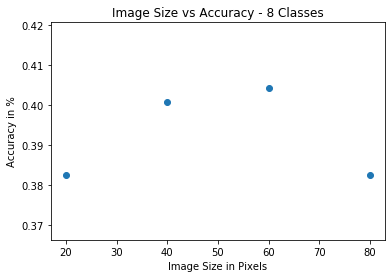

In [136]:
plt.scatter(image_resizes, accuracies);
plt.xlabel("Image Size in Pixels");
plt.ylabel("Accuracy in %");
plt.title(f"Image Size vs Accuracy - {Nber_of_breeds} Classes");